# XZ Backdoor Github Analysis

This notebook allows you to easily generate a timeline for a particular user's Github commit activity. It makes use of Github's [GraphQL API](https://docs.github.com/en/graphql), so you'll need to generate a [personal access token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/managing-your-personal-access-tokens) if you want to query new data. This was supposed to be just a quick one off script so the code quality isn't great.

The data currently being used in this visualization was captured at around 7:00PM EST on 2024/03/29. Since Github has removed the repository, if you refetch the data now, you will get different results.

There are plenty of plausable explanations for why the commits of interest occurred at such a strange time. Keep in mind that, by itself, none of this is a damning piece of evidence by any means. It is simply an interesting observation. I'm not making any claims about what this could mean, and will leave interpretation/speculation as an exercise to the reader.

Reminders:
- Commit dates are not immutable.
- People are weird.
- This is still a developing situation.

**Important caveat:** please **do not** start accusing random OSS authors of being malicious actors without **credible** evidence. It is already a thankless job and there is no need to make their lives harder. <3

In [3]:
import json
import requests 
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Add your personal access token here (don't really do this use a .env or something)
GITHUB_TOKEN = ""
GITHUB_GRAPHQL_URL = "https://api.github.com/graphql"

# Set the username and email here
variables = {
    "user": "JiaT75",
    "email": "jiat0218@gmail.com",
    "cursorRepo": None,
    "cursorCommit": None, 
}

In [2]:
def run_query(query, variables):
    """Run a query against Github's GraphQL API"""
    headers = {"Authorization": f"Bearer {GITHUB_TOKEN}"}
    request = requests.post(
        GITHUB_GRAPHQL_URL,
        json={"query": query, "variables": variables},
        headers=headers,
    )
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception(
            f"Query failed with status code {request.status_code}: {request.text}"
        )

## 1. Get all repositories that a user has commit activity on

If you want to get other contribution types (e.g PUSH), just modify the `contributionTypes` parameter.

In [5]:
query_user_repos = """
query ($user: String!){
  user(login: $user) {
    repositoriesContributedTo(includeUserRepositories: true, contributionTypes: COMMIT, first: 100) {
      totalCount
      pageInfo {
        hasNextPage
        endCursor
      }
      nodes {
        name
        owner {
          login
        }
      }
    }
  }
}
"""

# user_repos = run_query(query_user_repos, variables).get("data").get("user").get("repositoriesContributedTo").get("nodes")

## 2. Find all relevant commits for each repository 

This query was yoinked from [here](https://stackoverflow.com/a/77748151) as I don't know GraphQL.

In [17]:
query_repo = """
query($owner: String!, $name: String!, $author: CommitAuthor!, $cursorCommit: String) {
  repository(owner: $owner, name: $name) {
    defaultBranchRef {
      target {
        ... on Commit {
          history(author: $author, first: 100, after: $cursorCommit) {
            totalCount
            pageInfo {
              hasNextPage
              endCursor
            }
            nodes {
              oid
              messageHeadline
              committedDate
              author {
                name
                email
              }
            }
          }
        }
      }
    }
  }
}
"""

def get_all_commits(variables):
    """ Iterate over each repository and extract all commit objects """
    all_commits = {}
    for repo in user_repos:
        commits = []
        owner = repo["owner"]["login"]
        name = repo["name"]
        cursorCommit = None
    
        # You can only get 100 results at a time, so we iterate until there's
        # no more cursors available.
        while True:
            repo_variables = {
                "owner": owner,
                "name": name,
                "author": {"emails":variables["email"]},
                "cursorCommit": cursorCommit,
            }
            result = run_query(query_repo, repo_variables)
            commit_history = result["data"]["repository"]["defaultBranchRef"]["target"][
                "history"
            ]
            commits.extend(commit_history["nodes"])
            has_next_page = commit_history["pageInfo"]["hasNextPage"]
            if has_next_page:
                cursorCommit = commit_history["pageInfo"]["endCursor"]
            else:
                all_commits[name] = commits
                break
    return all_commits

# In this case, since the repo was removed, this is going to be the saved data taken yesterday.
# If you're querying a new user, simply comment out these lines.
local_testing = True
if local_testing:
    with open("data/2024-03-30-jait75.json", "r") as f:
        all_commits = json.loads(f.read())
else: 
    all_commits = get_all_commits(variables)

## 3. Visualization

Initially, I was just interested in how regular this author's commits were.

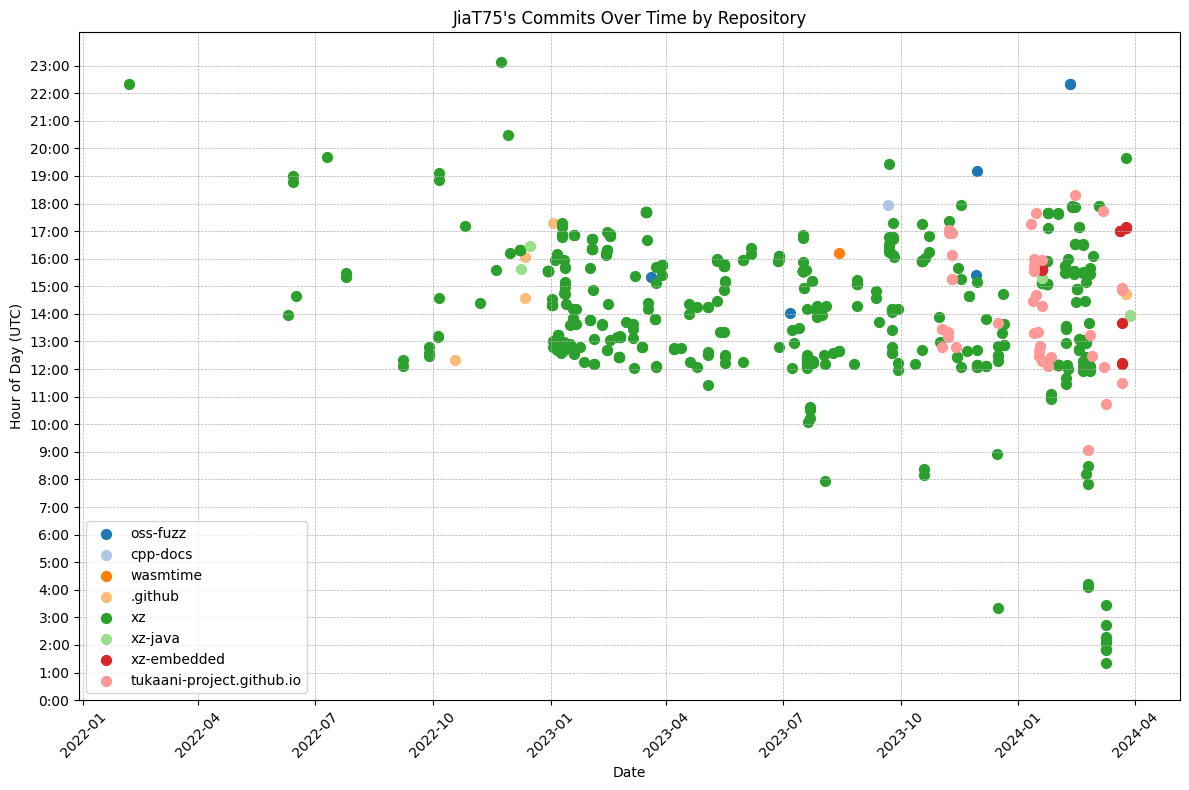

In [16]:
# Create another, smaller, structure for graphing, not necessary
timeline = {}
for repo in all_commits:
    timeline[repo] = []
    for i in all_commits.get(repo):
        timeline[repo].append(i["committedDate"])

# Convert dates to pandas datetime and compile into a DataFrame
df_list = []
for repo, dates in timeline.items():
    dates = [pd.to_datetime(date) for date in dates]  # Converting string dates to datetime objects
    df_list.append(pd.DataFrame({"Commit Date": dates, "Repository": repo}))
df = pd.concat(df_list)

# Extracting the hour for plotting
df['Commit Hour'] = df['Commit Date'].dt.hour + df['Commit Date'].dt.minute / 60

# Plotting
plt.figure(figsize=(12, 8))

colors = plt.cm.tab20(range(len(all_commits)))  # Assigning unique colors from a colormap

for (repo, color) in zip(all_commits.keys(), colors):
    repo_df = df[df["Repository"] == repo]
    plt.scatter(repo_df["Commit Date"].dt.date, repo_df["Commit Hour"], s=50, color=color, label=repo)

plt.xlabel("Date")
plt.ylabel("Hour of Day (UTC)")
plt.title(f"{variables.get('user')}'s Commits Over Time by Repository")
plt.legend()
plt.xticks(rotation=45)

# Generating half-hour ticks and labels
HALF_HOUR = False

if HALF_HOUR:
    half_hour_ticks = [hour + minute/2 for hour in range(24) for minute in range(2)]
    half_hour_labels = [f"{hour}:{'00' if minute == 0 else '30'}" for hour in range(24) for minute in range(2)]
    plt.yticks(half_hour_ticks, half_hour_labels)
else:
    hour_ticks = [hour for hour in range(24)]
    hour_labels = [f"{hour}:00" for hour in range(24)]
    plt.yticks(hour_ticks, hour_labels)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.savefig("images/jai-commit-graph.png")
plt.show()